In [1]:
# from mpstemmer import MPStemmer
# import string

# stemmer = MPStemmer()

# def preprocess_sentence(list_of_sentences):
#     preprocessed = []
#     for sentence in list_of_sentences:
#         sentence = sentence.translate(str.maketrans('','',string.punctuation))
#         sentence = sentence.lower()
#         sentence = stemmer.stem_kalimat(sentence)
#         preprocessed.append(sentence)
#     return preprocessed

In [1]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import string

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

def preprocess_sentence(list_of_sentences):
    preprocessed = []
    for sentence in list_of_sentences:
        sentence = sentence.translate(str.maketrans('','',string.punctuation))
        sentence = sentence.lower()
        sentence = stemmer.stem(sentence)
        preprocessed.append(sentence)
    return preprocessed

In [2]:
import pandas as pd
msrp_test_df = pd.read_csv('data/processed/msrp_test_translated_id.txt', sep='\t', quotechar='^')
msrp_train_df = pd.read_csv('data/processed/msrp_train_translated_id.txt', sep='\t', quotechar='^')

test_100_df = pd.read_csv('data/processed/msr_test_100_id.txt', sep='\t')
test_df = pd.read_csv('data/processed/msr_test_id.txt', sep='\t')
train_df = pd.read_csv('data/processed/msr_train_id.txt', sep='\t')

test_df = pd.concat([test_df, test_100_df], ignore_index=True, axis=0)

In [3]:
test_100_df['preprocessed_sentence1'] = preprocess_sentence(test_100_df['sentence1'])
test_100_df['preprocessed_sentence2'] = preprocess_sentence(test_100_df['sentence2'])

test_df['preprocessed_sentence1'] = preprocess_sentence(test_df['sentence1'])
test_df['preprocessed_sentence2'] = preprocess_sentence(test_df['sentence2'])

train_df['preprocessed_sentence1'] = preprocess_sentence(train_df['sentence1'])
train_df['preprocessed_sentence2'] = preprocess_sentence(train_df['sentence2'])

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

def extract_feat_1(df_train, df_test, inductive=True):
    if inductive:
        all_sentences = np.concatenate([df_train['preprocessed_sentence1'], df_train['preprocessed_sentence2']])
    else:
        all_sentences = np.concatenate([df_train['preprocessed_sentence1'], df_train['preprocessed_sentence2'],
                                        df_test['preprocessed_sentence1'], df_test['preprocessed_sentence2']])
    vec = CountVectorizer(binary=True)
    vec.fit(all_sentences)
    
    X1_train = vec.transform(df_train['preprocessed_sentence1']).toarray()
    X2_train = vec.transform(df_train['preprocessed_sentence2']).toarray()
    
    X1_test = vec.transform(df_test['preprocessed_sentence1']).toarray()
    X2_test = vec.transform(df_test['preprocessed_sentence2']).toarray()

    feat_1_train = [jaccard_score(x1, x2, average='binary') for x1, x2 in zip(X1_train, X2_train)]
    feat_1_test = [jaccard_score(x1, x2, average='binary') for x1, x2 in zip(X1_test, X2_test)]
    
    df_feat_train = pd.DataFrame(feat_1_train, columns=['Jaccard_Score'])
    df_feat_train['label'] = df_train['label']
    
    df_feat_test = pd.DataFrame(feat_1_test, columns=['Jaccard_Score'])
    df_feat_test['label'] = df_test['label']
    
    return df_feat_train, df_feat_test

In [5]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

def extract_for_train(df_train):
    all_sentences = np.concatenate([df_train['preprocessed_sentence1'], df_train['preprocessed_sentence2']])
    vec = CountVectorizer(binary=True)
    vec.fit(all_sentences)
    X1_train = vec.transform(df_train['preprocessed_sentence1']).toarray()
    X2_train = vec.transform(df_train['preprocessed_sentence2']).toarray()
    
    feat_1_train = [jaccard_score(x1, x2, average='binary') for x1, x2 in zip(X1_train, X2_train)]
    
    df_feat_train = pd.DataFrame(feat_1_train, columns=['Jaccard_Score'])
    df_feat_train['label'] = df_train['label']
        
    return df_feat_train

In [15]:
feature = pd.concat([train_df, X_train], axis=1)

In [6]:
train, test = extract_feat_1(train_df, test_df, inductive=False)

In [7]:
train.to_csv('data/features/feat_exp_2_a_train.csv', index=False)

In [8]:
test.to_csv("data/features/feat_exp_2_a_test.csv", index=False)

In [15]:
train, test = extract_feat_1(train_df, test_100_df, inductive=True)


In [9]:
test

,Jaccard_Score,label
0,0.368421,0
1,0.550000,1
2,0.466667,1
3,0.312500,0
4,0.200000,0
...,...,...
95,0.291667,0
96,0.347826,1
97,0.230769,0
98,0.600000,0


In [10]:
test.to_csv("data/features/feat_exp_2_a_test_100.csv", index=False)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

import joblib

from utils.evaluation_matrics import print_validasi
best_pipeline = joblib.load('model/best_model_skor_kesamaan.pkl')

y_pred = best_pipeline.predict(X_test)

print(f'Akurasi model terbaik: {accuracy_score(y_test, y_pred):.3f}')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print(f'Precision model terbaik: {precision:.3f}')
print(f'Recall model terbaik: {recall:.3f}')
f1_macro = f1_score(y_test, y_pred, average="macro")
print(f'F1 pengujian model terbaik: {f1_macro:.3f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Akurasi model terbaik: 0.709
Precision model terbaik: 0.684
Recall model terbaik: 0.698
F1 pengujian model terbaik: 0.687
[[385 193]
 [309 838]]


In [7]:
train = extract_for_train(train_df)

X_train = train.drop(columns=['label'])
y_train = train['label']

In [9]:
train

,Jaccard_Score,label
0,0.562500,1
1,0.476190,0
2,0.666667,1
3,0.391304,0
4,0.391304,1
...,...,...
4071,0.368421,1
4072,0.434783,0
4073,0.620690,1
4074,0.307692,1


In [18]:
feature.to_csv("data/features/feat_exp_2_a_msrp_jaccard_score.txt", index=False, sep='\t')

## SVM

[I 2024-06-20 20:39:50,226] A new study created in memory with name: no-name-c000866d-1182-4566-b0b7-d049d5815a2a
[I 2024-06-20 20:39:52,050] Trial 0 finished with value: 0.6665267213719679 and parameters: {'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__gamma': 1.0, 'svc__degree': 3}. Best is trial 0 with value: 0.6665267213719679.
[I 2024-06-20 20:39:55,587] Trial 1 finished with value: 0.6559421800834458 and parameters: {'svc__C': 0.6967897346979598, 'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__degree': 3}. Best is trial 0 with value: 0.6665267213719679.
[I 2024-06-20 20:39:58,188] Trial 2 finished with value: 0.3221745510518987 and parameters: {'svc__C': 4.9486452008506765, 'svc__kernel': 'poly', 'svc__gamma': 0.0027802507162990146, 'svc__degree': 3}. Best is trial 0 with value: 0.6665267213719679.
[I 2024-06-20 20:40:00,829] Trial 3 finished with value: 0.3221745510518987 and parameters: {'svc__C': 0.0011734249462215724, 'svc__kernel': 'poly', 'svc__gamma': 0.0004500846646107144

Akurasi: 0.683
Presisi: 0.674
Recall: 0.698
F1 validasi: 0.669
Confusion Matrix:
[[197  68]
 [191 360]]


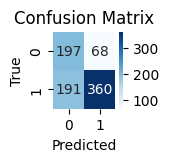

{'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__gamma': 1.0, 'svc__degree': 3}


In [13]:
import classifiers.svm as svm
gs, model = svm.find_best_param_svm(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=1.0, svc__degree=3, svc__gamma=1.0, svc__kernel=linear; total time=   1.1s
[CV] END svc__C=1.0, svc__degree=3, svc__gamma=1.0, svc__kernel=linear; total time=   0.9s
[CV] END svc__C=1.0, svc__degree=3, svc__gamma=1.0, svc__kernel=linear; total time=   0.8s
[CV] END svc__C=1.0, svc__degree=3, svc__gamma=1.0, svc__kernel=linear; total time=   0.8s
[CV] END svc__C=1.0, svc__degree=3, svc__gamma=1.0, svc__kernel=linear; total time=   0.8s
Akurasi: 0.683
Presisi: 0.674
Recall: 0.698
F1 validasi: 0.669
Confusion Matrix:
[[197  68]
 [191 360]]


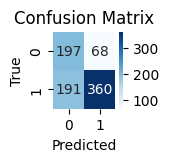

In [6]:
import classifiers.svm as svm
param = {'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__gamma': 1.0, 'svc__degree': 3}
param = {k: [v] for k,v in param.items()}
gs, model = svm.fit_train_svm(X_train, y_train, param=param)

# XGB

[I 2024-08-05 14:12:53,529] A new study created in memory with name: no-name-7fb73839-c079-4549-b6dd-c8aa21a486e1
[I 2024-08-05 14:12:55,573] Trial 0 finished with value: 0.6624476218675167 and parameters: {'xgbclassifier__eta': 0.3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__subsample': 1.0, 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 0.0, 'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__objective': 'reg:squarederror'}. Best is trial 0 with value: 0.6624476218675167.
[I 2024-08-05 14:12:57,198] Trial 1 finished with value: 0.6815834695228199 and parameters: {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weig

Akurasi: 0.708
Presisi: 0.679
Recall: 0.694
F1 validasi: 0.683
Confusion Matrix:
[[173  92]
 [146 405]]


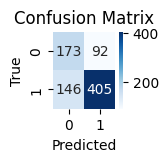

{'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}


In [58]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = [param]
gs, model = xgb.find_best_param_xgb(X_train, y_train, list_param=param,n_trials=500)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

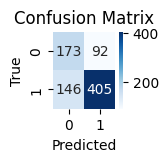

In [21]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

# Best Model Start

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

<Figure size 3000x3000 with 0 Axes>

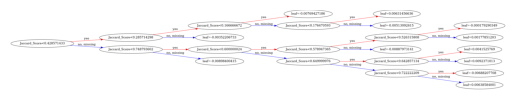

In [27]:
import classifiers.xgb as xgb

train, test = extract_feat_1(train_df, test_100_df, inductive=True)

X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   1.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.7s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

<Figure size 3000x3000 with 0 Axes>

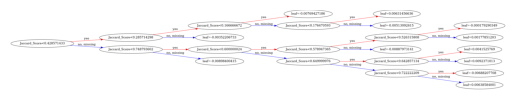

In [7]:
import classifiers.xgb as xgb

train, test = extract_feat_1(train_df, test_100_df, inductive=False)

X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

In [8]:
test

,Jaccard_Score,label
0,0.368421,0
1,0.550000,1
2,0.466667,1
3,0.312500,0
4,0.200000,0
...,...,...
95,0.291667,0
96,0.347826,1
97,0.230769,0
98,0.600000,0


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

<Figure size 3000x3000 with 0 Axes>

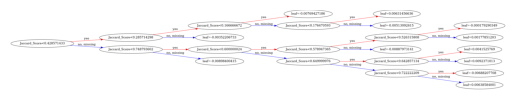

In [28]:
import classifiers.xgb as xgb

train, test = extract_feat_1(train_df, test_df, inductive=True)

X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.5s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.6s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

<Figure size 3000x3000 with 0 Axes>

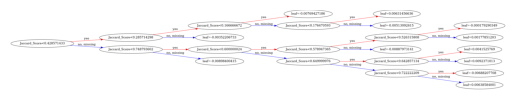

In [37]:
import classifiers.xgb as xgb

train, test = extract_feat_1(train_df, test_df, inductive=False)

X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

In [38]:
test

,Jaccard_Score,label
0,0.282051,1
1,0.681818,1
2,0.586207,0
3,0.619048,1
4,0.333333,0
...,...,...
1720,0.291667,0
1721,0.347826,1
1722,0.230769,0
1723,0.600000,0


In [39]:
test.to_csv("data/features/feat_exp_2_a_test.csv", index=False)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.6s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

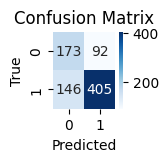

In [31]:
import classifiers.xgb as xgb

train, test = extract_feat_1(train_df, test_100_df, inductive=True)

X_train = train.drop(columns=['label'])
y_train = train['label']

param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

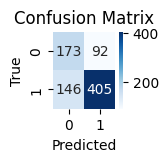

In [33]:
import classifiers.xgb as xgb

train, test = extract_feat_1(train_df, test_df, inductive=False)

X_train = train.drop(columns=['label'])
y_train = train['label']

param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

# Best Model End


In [35]:
import joblib

joblib.dump(model, 'model/best_model_skor_kesamaan.pkl')

['model/best_model_skor_kesamaan.pkl']

Akurasi: 0.708
Presisi: 0.679
Recall: 0.694
F1 validasi: 0.683
Confusion Matrix:
[[173  92]
 [146 405]]


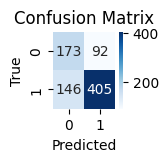

In [41]:
import joblib

from utils.evaluation_matrics import print_validasi
best_pipeline = joblib.load('model/best_model_skor_kesamaan.pkl')

print_validasi(best_pipeline, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.8s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

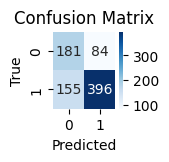

In [7]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.4s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

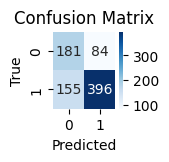

In [13]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

<Figure size 3000x3000 with 0 Axes>

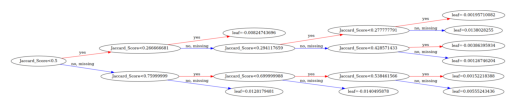

In [48]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   1.3s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

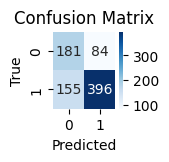

In [13]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

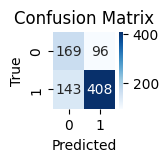

In [54]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.4s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

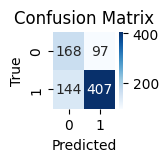

In [57]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

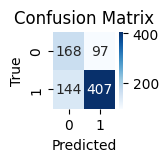

In [61]:
import classifiers.xgb as xgb
param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

<Figure size 3000x3000 with 0 Axes>

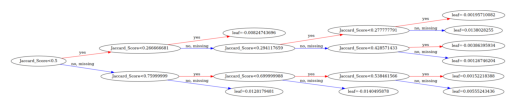

In [15]:
import classifiers.xgb as xgb

param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

<Figure size 3000x3000 with 0 Axes>

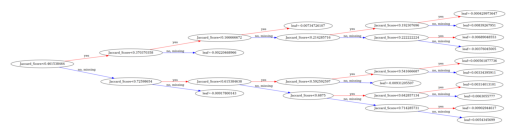

In [49]:
X_test = test.drop(columns=['label'])
y_test = test['label']
param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

<Figure size 3000x3000 with 0 Axes>

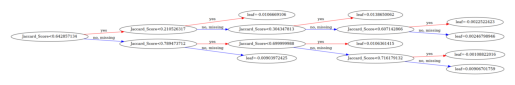

Akurasi model terbaik: 0.708
Precision model terbaik: 0.682
Recall model terbaik: 0.696
F1 pengujian model terbaik: 0.686
[[380 198]
 [305 842]]


In [55]:
import classifiers.xgb as xgb

param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

import joblib

from utils.evaluation_matrics import print_validasi
best_pipeline = joblib.load('model/best_model_skor_kesamaan.pkl')

y_pred = model.predict(X_test)

print(f'Akurasi model terbaik: {accuracy_score(y_test, y_pred):.3f}')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print(f'Precision model terbaik: {precision:.3f}')
print(f'Recall model terbaik: {recall:.3f}')
f1_macro = f1_score(y_test, y_pred, average="macro")
print(f'F1 pengujian model terbaik: {f1_macro:.3f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__su

<Figure size 3000x3000 with 0 Axes>

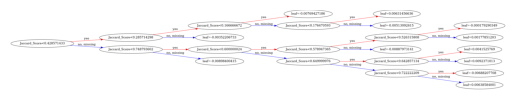

In [252]:
import classifiers.xgb as xgb

train_1, test_1 = extract_feat_1(train_df, test_df, inductive=False)

X_train = train_1.drop(columns=['label'])
y_train = train_1['label']

X_test = test_1.drop(columns=['label'])
y_test = test_1['label']
param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.4s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier

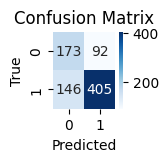

In [253]:
import classifiers.xgb as xgb

train_1= extract_for_train(train_df)

X_train = train_1.drop(columns=['label'])
y_train = train_1['label']

# X_test = test_1.drop(columns=['label'])
# y_test = test_1['label']
param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__subsample=0.6605185303373765; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.794974846558151, xgbclassifier__eta=0.2098656020565554, xgbclassifier__gamma=3.033596934723031, xgbclassifier__learning_rate=0.010045690580372323, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=446, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=2.363502995354647, xgbclassifier__su

<Figure size 3000x3000 with 0 Axes>

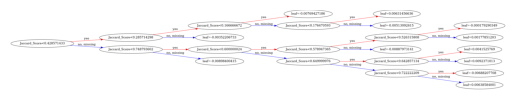

In [254]:
import classifiers.xgb as xgb

train_1, test_1 = extract_feat_1(train_df, test_100_df, inductive=False)

X_train = train_1.drop(columns=['label'])
y_train = train_1['label']

X_test = test_1.drop(columns=['label'])
y_test = test_1['label']
param = {'xgbclassifier__eta': 0.2098656020565554, 'xgbclassifier__n_estimators': 446, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.010045690580372323, 'xgbclassifier__subsample': 0.6605185303373765, 'xgbclassifier__colsample_bytree': 0.794974846558151, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__gamma': 3.033596934723031, 'xgbclassifier__reg_lambda': 2.363502995354647, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
gs, model = xgb.fit_and_test_xgb(X_train, y_train, X_test, y_test, param=param)

In [16]:

param = {'xgbclassifier__eta': 0.026214976707038106, 'xgbclassifier__n_estimators': 326, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.015428730196279876, 'xgbclassifier__subsample': 0.5797419574455537, 'xgbclassifier__colsample_bytree': 0.7873549051558703, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 3.817349832271725, 'xgbclassifier__reg_lambda': 3.533850328457086, 'xgbclassifier__objective': 'binary:hinge'}
param = {k: [v] for k,v in param.items()}
xgb.fit_train_xgb_doang(X_train, y_train, param=param)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbclassifier__eta=0.026214976707038106, xgbclassifier__gamma=3.817349832271725, xgbclassifier__learning_rate=0.015428730196279876, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=326, xgbclassifier__objective=binary:hinge, xgbclassifier__reg_lambda=3.533850328457086, xgbclassifier__subsample=0.5797419574455537; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.7873549051558703, xgbcla

# RF

[I 2024-06-20 20:52:22,178] A new study created in memory with name: no-name-99408f96-a36f-472f-813b-d175b61ed063
[I 2024-06-20 20:52:23,238] Trial 0 finished with value: 0.6517127673967715 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.6517127673967715.
[I 2024-06-20 20:52:26,488] Trial 1 finished with value: 0.6628091677922807 and parameters: {'randomforestclassifier__n_estimators': 387, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6628091677922807.
[I 2024-06-20 20:52:28,745] Trial 2 finished with value: 0.651

Akurasi: 0.686
Presisi: 0.673
Recall: 0.696
F1 validasi: 0.671
Confusion Matrix:
[[192  73]
 [183 368]]


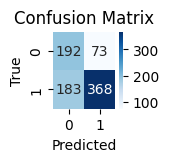

{'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 20, 'randomforestclassifier__bootstrap': False}


In [20]:
gs, model = find_best_param_rf(X_train, y_train, timeout=300)

[I 2024-06-20 20:59:22,058] A new study created in memory with name: no-name-55603eca-3ce0-40e4-9e67-8d5888370dbe
[I 2024-06-20 20:59:23,170] Trial 0 finished with value: 0.6517127673967715 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.6517127673967715.
[I 2024-06-20 20:59:26,079] Trial 1 finished with value: 0.6628091677922807 and parameters: {'randomforestclassifier__n_estimators': 387, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6628091677922807.
[I 2024-06-20 20:59:28,218] Trial 2 finished with value: 0.666

Akurasi: 0.664
Presisi: 0.668
Recall: 0.692
F1 validasi: 0.655
Confusion Matrix:
[[204  61]
 [213 338]]


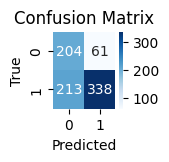

{'randomforestclassifier__n_estimators': 242, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 11, 'randomforestclassifier__bootstrap': False}


In [23]:
gs, model = find_best_param_rf(X_train, y_train, timeout=300)

[I 2024-06-20 21:05:59,138] A new study created in memory with name: no-name-1f804905-7804-4e5a-91e1-79c86ddda2f3
[I 2024-06-20 21:06:01,081] Trial 0 finished with value: 0.6517127673967715 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.6517127673967715.
[I 2024-06-20 21:06:04,928] Trial 1 finished with value: 0.6628091677922807 and parameters: {'randomforestclassifier__n_estimators': 387, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6628091677922807.
[I 2024-06-20 21:06:07,493] Trial 2 finished with value: 0.666

Akurasi: 0.664
Presisi: 0.668
Recall: 0.692
F1 validasi: 0.655
Confusion Matrix:
[[204  61]
 [213 338]]


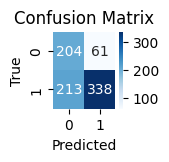

{'randomforestclassifier__n_estimators': 242, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 11, 'randomforestclassifier__bootstrap': False}


In [26]:
gs, model = find_best_param_rf(X_train, y_train, timeout=100)


[I 2024-06-20 21:08:18,620] A new study created in memory with name: no-name-7b83ef3e-b26e-410d-8099-896c3f3d64b9
[I 2024-06-20 21:08:19,929] Trial 0 finished with value: 0.6517127673967715 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.6517127673967715.
[I 2024-06-20 21:08:23,478] Trial 1 finished with value: 0.6628091677922807 and parameters: {'randomforestclassifier__n_estimators': 387, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6628091677922807.
[I 2024-06-20 21:08:25,598] Trial 2 finished with value: 0.666

Akurasi: 0.664
Presisi: 0.668
Recall: 0.692
F1 validasi: 0.655
Confusion Matrix:
[[204  61]
 [213 338]]


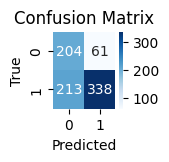

{'randomforestclassifier__n_estimators': 242, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 11, 'randomforestclassifier__bootstrap': False}


In [27]:
gs, model = find_best_param_rf(X_train, y_train, timeout=100)


[I 2024-06-20 21:10:14,599] A new study created in memory with name: no-name-bdde1374-fbd1-4628-8769-2e96ddb53eec
[I 2024-06-20 21:10:16,650] Trial 0 finished with value: 0.6517127673967715 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.6517127673967715.
[I 2024-06-20 21:10:19,940] Trial 1 finished with value: 0.6628091677922807 and parameters: {'randomforestclassifier__n_estimators': 387, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6628091677922807.
[I 2024-06-20 21:10:21,997] Trial 2 finished with value: 0.666

Akurasi: 0.664
Presisi: 0.668
Recall: 0.692
F1 validasi: 0.655
Confusion Matrix:
[[204  61]
 [213 338]]


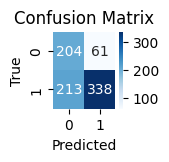

{'randomforestclassifier__n_estimators': 242, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 11, 'randomforestclassifier__bootstrap': False}


In [28]:
gs, model = find_best_param_rf(X_train, y_train, timeout=100)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=None, randomforestclassifier__max_leaf_nodes=20, randomforestclassifier__n_estimators=250; total time=   0.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=None, randomforestclassifier__max_leaf_nodes=20, randomforestclassifier__n_estimators=250; total time=   0.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=None, randomforestclassifier__max_leaf_nodes=20, randomforestclassifier__n_estimators=250; total time=   0.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=gini, randomforestclassifier__ma

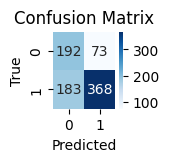

In [6]:
import classifiers.rf as rf

param = {'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 20, 'randomforestclassifier__bootstrap': False}
param = {k :[v] for k,v in param.items()}
_, _ = rf.fit_train_rf(X_train, y_train, param)

# LGBM

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=goss, lgbmclassifier__colsample_bytree=0.5634777500220061, lgbmclassifier__learning_rate=0.19968980718274815, lgbmclassifier__max_depth=1, lgbmclassifier__min_data_in_leaf=15, lgbmclassifier__n_estimators=620, lgbmclassifier__num_leaves=33, lgbmclassifier__reg_alpha=2.5825780039592945, lgbmclassifier__reg_lambda=9.7497937056175, lgbmclassifier__subsample=0.7071677794552967; total time=   0.2s
[CV] END lgbmclassifier__boosting=goss, lgbmclassifier__colsample_bytree=0.5634777500220061, lgbmclassifier__learning_rate=0.19968980718274815, lgbmclassifier__max_depth=1, lgbmclassifier__min_data_in_leaf=15, lgbmclassifier__n_estimators=620, lgbmclassifier__num_leaves=33, lgbmclassifier__reg_alpha=2.5825780039592945, lgbmclassifier__reg_lambda=9.7497937056175, lgbmclassifier__subsample=0.7071677794552967; total time=   0.2s
[CV] END lgbmclassifier__boosting=goss, lgbmclassifier__colsample_bytree=0.563477

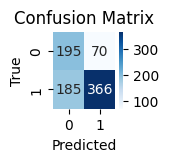

In [8]:
import classifiers.lgbm as lgbm

param = {'lgbmclassifier__num_leaves': 33, 'lgbmclassifier__min_data_in_leaf': 15, 'lgbmclassifier__max_depth': 1, 'lgbmclassifier__learning_rate': 0.19968980718274815, 'lgbmclassifier__n_estimators': 620, 'lgbmclassifier__subsample': 0.7071677794552967, 'lgbmclassifier__colsample_bytree': 0.5634777500220061, 'lgbmclassifier__reg_alpha': 2.5825780039592945, 'lgbmclassifier__reg_lambda': 9.7497937056175, 'lgbmclassifier__boosting': 'goss'}
param = {k: [v] for k,v in param.items()}
_, _ = lgbm.fit_train_lgbm(X_train, y_train, param)